AnnData object with n_obs × n_vars = 36601 × 2711
AnnData object with n_obs × n_vars = 2711 × 36601
2711
36601


Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 2711 × 21256
    obs: 'n_genes'
    var: 'n_cells'
2711
21256
View of AnnData object with n_obs × n_vars = 2711 × 21256
    obs: 'n_genes'
    var: 'n_cells'
View of AnnData object with n_obs × n_vars = 2711 × 3774
    obs: 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


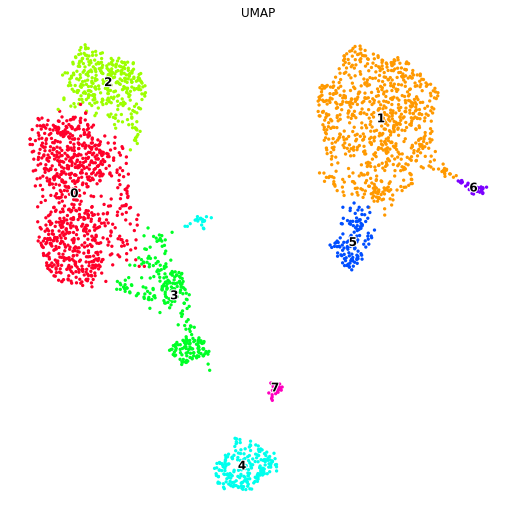

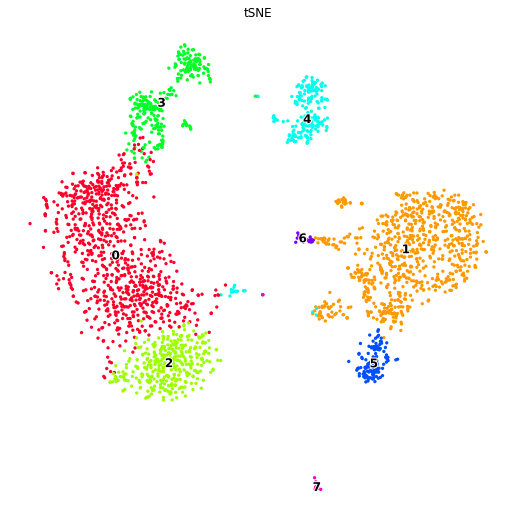

0 : 863
1 : 798
2 : 351
3 : 290
4 : 221
5 : 119
6 : 36
7 : 33
AnnData object with n_obs × n_vars = 6 × 2711
AnnData object with n_obs × n_vars = 2711 × 6


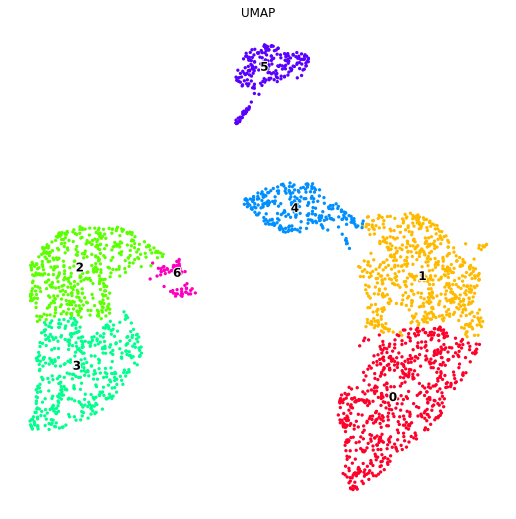

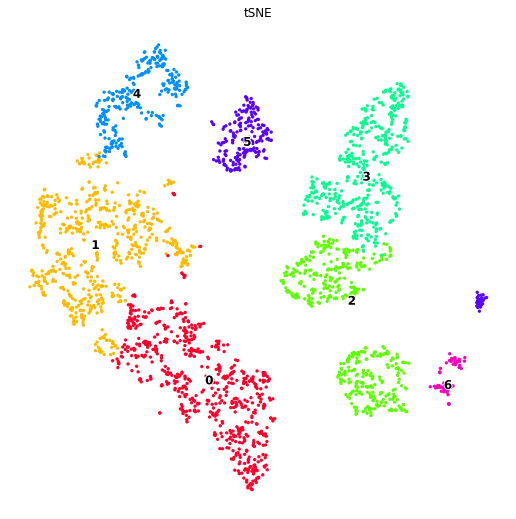

0 : 641
1 : 615
2 : 458
3 : 439
4 : 269
5 : 221
6 : 68
silhouette_avg:  0.42529157 0.5007911
RNA: 6
RNA: 5
RNA: 7
ATAC: 6
$$$$$$$ 
 
$$$$$$$ 
 
$$$$$$$ 
 
$$$$$$$ 
 
$$$$$$$ 
 
$$$$$$$ 
 
$$$$$$$ 
 
$$$$$$$ 
 
$$$$$$$ 
 
$$$$$$$ 
 
(2523, 3774) (2185, 18079)
2095
   res1  cls_r_raw  cls_r     sil_r  res2  cls_a_raw  cls_a     sil_a  \
0   0.2        8.0    5.0  0.425292  0.17        7.0    5.0  0.500791   

   len(RNA)  len(ATAC)  Overlap  
0    2523.0     2185.0   2095.0  
3485 1252
86015 18079
0 1
1 3
2 0
3 4
4 5
Line 166. >>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 493.8662893772125
lambda, lev, n_neigh, n_iter, FOSCTTM1, FOSCTTM2:  0.8 2 3 0 0.15314500284539495 0.14682836189461052
2095.0 2095.0
2095 2095
Final FOSCTTM XonY and YonX:  0.15314500284539495 0.14682836189461052


In [2]:
import sys
sys.path.insert(0, '/home/ejafari/alignment/Git/src/')
from utils import *
from AIscEA import *
from evals import *
from rmCls import *
from similarity import *
from collections import Counter
from sklearn.metrics import silhouette_samples, silhouette_score

import warnings
warnings.filterwarnings('ignore')


res_df = pd.DataFrame(columns=['res1', 'cls_r_raw', 'cls_r', 'sil_r', 'res2', 'cls_a_raw', 'cls_a', 'sil_a', 'len(RNA)', 'len(ATAC)', 'Overlap'])
for res1 in [0.2]:
    for res2 in [0.17]:


        ############################ High_var = True ######################################
        input_dir = "/home/ejafari/alignment/downstream/data/PBMC_3k/mine/"
        # Find marker genes of scRNAseq data
        markers_rna, rna = scRNAseq_clustering_original(input_dir + 'rna.csv', filtering=True, resl=res1, highly_var=True, tr=True, n_pc=15)


        cls_r_raw = len(set(rna.obs['leiden']))
        
        # Find clusters of low dimensional cisTopic result for scATACseq
        atac = clustering(input_dir + 'atac_topics.tsv', transpose=True, resl=res2)


        ############################ scATAC ######################################
        # 1) Put cisTopic clusters and embedding values on the original data and 2) find marker genes and their logFC
        f_original = 'pred_matrix_closest_genes_1k_downstream_strand_first_prom.csv'
        markers_atac, atac_cis_on_org = process_cisTopic_on_orig(atac, f_original, input_dir, save=False, transpose=True)

        # To match name of the cells in RNA and ATAC data
        atac_cis_on_org.obs.index = [i.replace('.','-') for i in atac_cis_on_org.obs.index] 

        cls_a_raw = len(set(atac_cis_on_org.obs['leiden']))
        
        
        silhouette_avg_r = silhouette_score(rna.obsm['X_umap'], rna.obs['leiden'])
        silhouette_avg_a = silhouette_score(atac_cis_on_org.obsm['X_umap'], atac_cis_on_org.obs['leiden'])

        print("silhouette_avg: ", silhouette_avg_r, silhouette_avg_a)


        rna, atac_cis_on_org,  markers_rna, markers_atac = rm_tiny_cluster(rna, atac_cis_on_org,markers_rna, markers_atac, min_cells=200, rm_correspondence=False)

        col_ind, rna, atac_cis_on_org = extract_mapped_clusters(rna, markers_rna, atac_cis_on_org, markers_atac, p_val_count=6)

        try:
            print(rna.shape, atac_cis_on_org.shape)
            overlap = len(set(rna.obs.index) & set(atac_cis_on_org.obs.index))
            print(overlap)

            res_df.loc[len(res_df)] = [res1, cls_r_raw, len(set(rna.obs['leiden'])), silhouette_avg_r, res2, cls_a_raw, len(set(atac_cis_on_org.obs['leiden'])), silhouette_avg_a, rna.shape[0], atac_cis_on_org.shape[0], overlap]
        except:
            res_df.loc[len(res_df)] = [res1, res2,  None, None, None, None, None, None, None, None, 0]
            
            
#         res_df.to_csv('10k_loop_params_.csv', index=True)


print(res_df)

# aligns_dict = AIscEA(col_ind, rna, markers_rna, atac_cis_on_org, markers_atac)
aligns_dict, fracs1_all, fracs2_all = AIscEA(col_ind, rna, markers_rna, atac_cis_on_org, markers_atac)    
        


## Overlap coef and silhoutte score

In [5]:
##### Double check the true mappings using cell labels

df_cells_common = pd.DataFrame()

for cls_rna in sorted(set(rna.obs['leiden'])):
    for cls_atac in sorted(set(atac_cis_on_org.obs['leiden'])):
        cells_atac  = atac_cis_on_org.obs[atac_cis_on_org.obs['leiden'] == str(cls_atac)].index
        cells_rna = rna.obs[rna.obs['leiden'] == str(cls_rna)].index
        df_cells_common.loc[('r_' + str(cls_rna)), ('a_' + str(cls_atac))] = len(set(cells_atac) & set(cells_rna))
        
df_cells_common







,a_0,a_1,a_3,a_4,a_5
r_0,331.0,529.0,0.0,3.0,0.0
r_1,0.0,0.0,379.0,0.0,0.0
r_2,307.0,43.0,0.0,1.0,0.0
r_3,0.0,29.0,0.0,259.0,1.0
r_4,3.0,14.0,0.0,6.0,190.0


In [7]:
# Double check the true mappings using cell labels
import pickle
import pandas as pd
df_cells_common = pd.DataFrame(columns=['overlap', 'union', 'jacc', 'overlap/min'])
out_dir = "/home/ejafari/alignment/downstream/notebooks/FW_cluster_cell_names/Mus_5k/"
cls_overlap_dict = dict()

for cls_rna in sorted(set(rna.obs['leiden'])):
    cls_atac = str(col_ind[int(cls_rna)])
    cells_atac  = atac_cis_on_org.obs[atac_cis_on_org.obs['leiden'] == str(cls_atac)].index
    cells_rna = rna.obs[rna.obs['leiden'] == str(cls_rna)].index
    overlap = set(cells_atac) & set(cells_rna)
    n_overlapping = len(overlap)
    cls_overlap_dict[cls_rna + "_" + cls_atac] = overlap
    

        
    n_union = len(set(cells_rna).union(cells_atac))
    jacc = n_overlapping/n_union
    overlap_min = n_overlapping/min(len(cells_rna), len(cells_atac))
    df_cells_common.loc['r_' + str(cls_rna) + '_a_' + str(cls_atac)] = [n_overlapping, n_union, jacc, overlap_min]

    print(cls_rna, cls_atac, len(cells_rna), len(cells_atac), n_union, n_overlapping, jacc) 
    
    # Save overlapping cell names in mapped clusters
with open(out_dir + 'overlap_mapped_clusters.pickle', 'wb') as handle:
    pickle.dump(cls_overlap_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
df_cells_common

# 0:2, 1:1, 3:8, 5:0, 4:10


0 1 863 615 949 529 0.5574288724973656
1 3 798 439 858 379 0.4417249417249417
2 0 351 641 685 307 0.4481751824817518
3 4 290 269 300 259 0.8633333333333333
4 5 221 221 252 190 0.753968253968254


,overlap,union,jacc,overlap/min
r_0_a_1,529.0,949.0,0.557429,0.860163
r_1_a_3,379.0,858.0,0.441725,0.863326
r_2_a_0,307.0,685.0,0.448175,0.874644
r_3_a_4,259.0,300.0,0.863333,0.962825
r_4_a_5,190.0,252.0,0.753968,0.859729


In [8]:
np.mean(df_cells_common['overlap/min'])

0.8841372004373074

# UMAP Figures

AnnData object with n_obs × n_vars = 36601 × 2711
AnnData object with n_obs × n_vars = 2711 × 36601
2711
36601


Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 2711 × 21256
    obs: 'n_genes'
    var: 'n_cells'
2711
21256
View of AnnData object with n_obs × n_vars = 2711 × 21256
    obs: 'n_genes'
    var: 'n_cells'
View of AnnData object with n_obs × n_vars = 2711 × 3774
    obs: 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


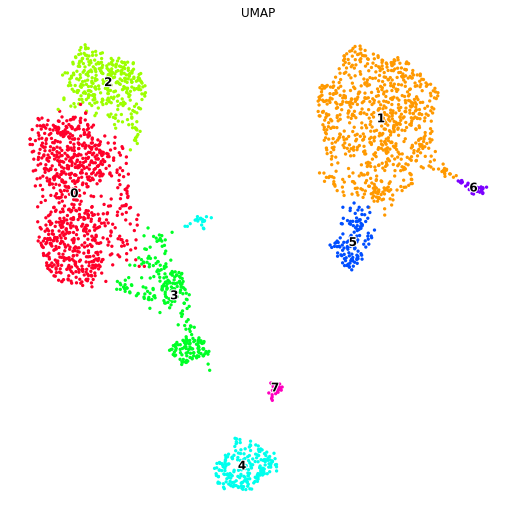

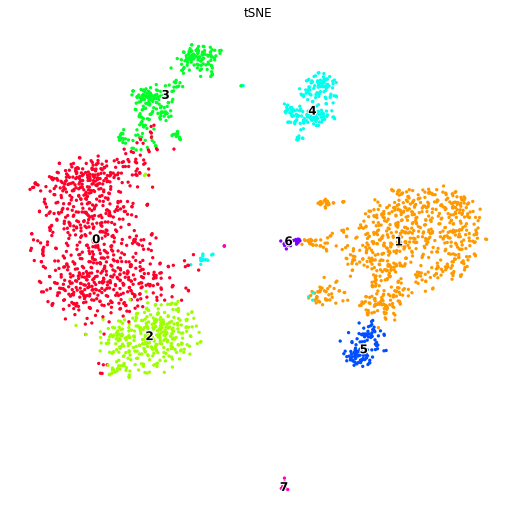

0 : 863
1 : 798
2 : 351
3 : 290
4 : 221
5 : 119
6 : 36
7 : 33
AnnData object with n_obs × n_vars = 6 × 2711
AnnData object with n_obs × n_vars = 2711 × 6


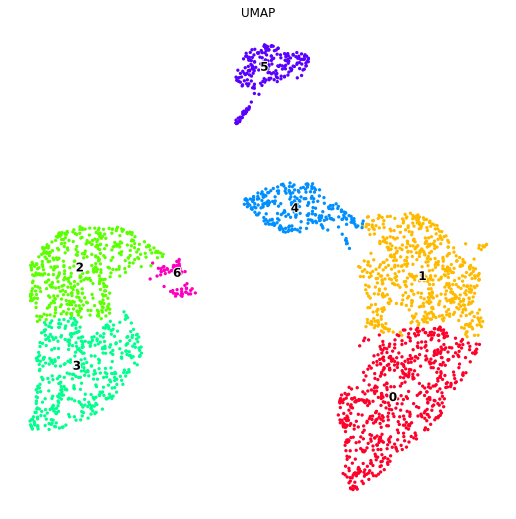

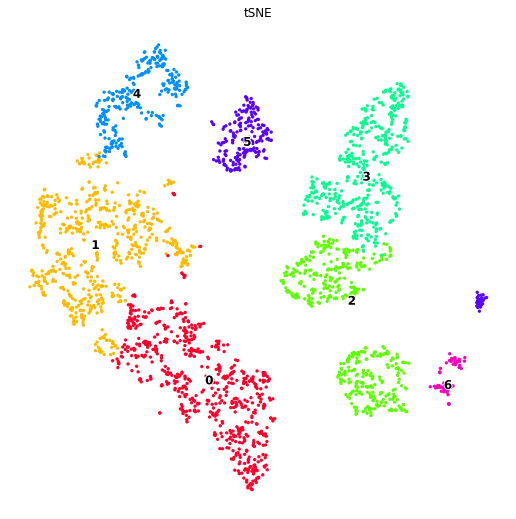

0 : 641
1 : 615
2 : 458
3 : 439
4 : 269
5 : 221
6 : 68


In [3]:
input_dir = "/home/ejafari/alignment/downstream/data/PBMC_3k/mine/"
# Find marker genes of scRNAseq data
markers_rna, rna = scRNAseq_clustering_original(input_dir + 'rna.csv', filtering=True, resl=res1, highly_var=True, tr=True, n_pc=15)


cls_r_raw = len(set(rna.obs['leiden']))

# Find clusters of low dimensional cisTopic result for scATACseq
atac = clustering(input_dir + 'atac_topics.tsv', transpose=True, resl=res2)


############################ scATAC ######################################
# 1) Put cisTopic clusters and embedding values on the original data and 2) find marker genes and their logFC
f_original = 'pred_matrix_closest_genes_1k_downstream_strand_first_prom.csv'
markers_atac, atac_cis_on_org = process_cisTopic_on_orig(atac, f_original, input_dir, save=False, transpose=True)

# To match name of the cells in RNA and ATAC data
atac_cis_on_org.obs.index = [i.replace('.','-') for i in atac_cis_on_org.obs.index] 

In [4]:
col_ind = {0: 1, 1: 3, 2: 0, 3: 4, 4: 5}
cats_rna = [int(i) for i in rna.obs['leiden'].cat.categories]
cats_atac = [int(i) for i in atac_cis_on_org.obs['leiden'].cat.categories]

for i in range(5):
    print(rna.uns['leiden_colors'][cats_rna.index(i)], atac.uns['leiden_colors'][cats_atac.index(i)])





#ff0029 #ff0029
#ff9900 #ffba00
#9dff00 #5cff00
#00ff26 #00ff8c
#00ffed #008fff


In [9]:
colors = ["#ff0029", "#ffff00", "#00ff8c", "#0018ff", "#ff00bf"]

0 #00ff8c
1 #ff0029
2 2
3 #ffff00
4 #0018ff
5 #ff00bf
6 6


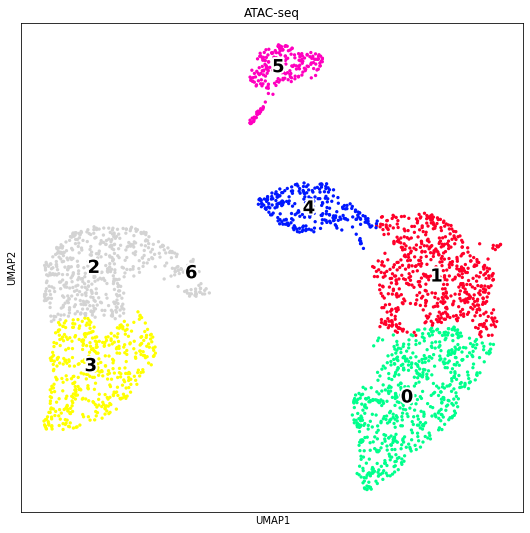

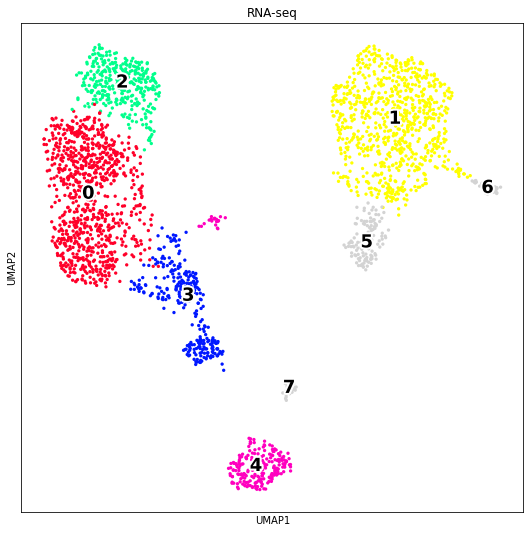

In [10]:
for cls in range(len(rna.uns['leiden_colors'])):
    if cls not in col_ind.keys():
        rna.uns['leiden_colors'][cats_rna.index(cls)] = '#D3D3D3' # Light grey

atac_cis_on_org.uns['leiden_colors'] = atac.uns['leiden_colors'] 


for cls in range(len(atac_cis_on_org.uns['leiden_colors'])):
    if cls not in col_ind.values():
        atac_cis_on_org.uns['leiden_colors'][cats_atac.index(cls)] = '#D3D3D3' # Light grey
        print(cls, cats_atac.index(cls))
    else:
        print(cls, atac_cis_on_org.uns['leiden_colors'][cats_atac.index(cls)])
        for cls_r, cls_a in col_ind.items():
            atac_cis_on_org.uns['leiden_colors'][cats_atac.index(cls_a)] = colors[cls_r]
            rna.uns['leiden_colors'][cats_rna.index(cls_r)] = colors[cls_r]

sc.pl.umap(atac_cis_on_org, color=['leiden'], legend_loc='on data', legend_fontsize=18, legend_fontoutline=4,frameon=True, title='ATAC-seq', save='PBMC_3k_ATAC_grey.svg')#
sc.pl.umap(rna, color=['leiden'], legend_loc='on data', legend_fontsize=18, legend_fontoutline=4,frameon=True, title='RNA-seq', save='PBMC_3k_RNA_grey.svg')#